# Adaptive numerical integration

In this project, we apply numerical methods to adaptively compute a definite integral of the type:
$$I(f) = \int_a^b f(x)\, dx$$
a process also called *numerical integration*.

We are going to apply the Cavalieri-Simpson integration method on subintervals $[\alpha, \beta]$ of the entire integration range $[a,b]$, with $[\alpha, \beta] \subseteq [a,b]$.

For reference, see (in italian) [Quarteroni, A., Saleri, F., Sacco, R. (2007), *Matematica numerica*, Milano: Springer](https://www.amazon.it/Matematica-Numerica-Unitext-Quarteroni/dp/8847000777).

## Cavalieri-Simpson rule

The [Cavalieri-Simpson rule](https://en.wikipedia.org/wiki/Simpson's_rule) approximates a definite integral of a function $f$ on an interval $[\alpha, \beta]$ by calculating the definite integral of the polynomial of the second order $P$ (a quadratic polynomial, representing a *parabola*) interpolated on the extremis and midpoint of the interval, in the points: $f(\alpha)$, $f(\frac{\beta + \alpha}{2})$ and $f(\beta)$.

Considering the integral $I_f(\alpha, \beta) = \int_\alpha^\beta f(x)\,dx$, the stepsize $h_0 = \frac{\beta - \alpha}{2}$ (different from midpoint $\frac{\beta + \alpha}{2}$) and the quadratic interpolant of $f$, $P$:

$$S_f(\alpha, \beta) = \int_\alpha^\beta P(x)\,dx = \frac{h_0}{3} \Big[f(\alpha) + 4 f(\alpha + h_0) + f(\beta)\Big]$$

This approximation produces an error:

$$E_{Sf}(\alpha, \beta) = I_f(\alpha, \beta) - S_f(\alpha, \beta) = - \frac{h_0^5}{90} f^{(4)}(\xi)$$

where $\xi \in (\alpha, \beta)$.

In [1]:
def simpson_rule(func, alpha, beta):
    """
    Approximate the integrand function `func` with a quadrating interpolant.
    
    :param func: function object to use to evaluate
    :param alpha: left extreme of integration
    :param beta: right extreme of integration
    :returns: approximate integral value
    """
    stepsize = (beta - alpha) * 0.5
    return (stepsize / 3) * (func(alpha) + 4 * func(alpha + stepsize) + func(beta))

In [2]:
func = lambda x: x**2
_a, _b = 0, 1

print("The definite integral of x^2 on the interval (0, 1), approximated "
      "with the Cavalieri-Simpson method, is: {:.4f}.".format(
          simpson_rule(func, _a, _b)
      ))

assert abs(simpson_rule(func, _a, _b) - (1 / 3)) <= 1e-6

The definite integral of x^2 on the interval (0, 1), approximated with the Cavalieri-Simpson method, is: 0.3333.


### Error estimation

To estimate the error $E_{Sf}$ produced when using Simpson's rule, without calculating $f^{(4)}(\xi)$, we can calculate the error $E_{Sf2}$ that would result from computing the definite integral $S_{f2}$ on the two subintervals $[\alpha, \frac{\beta + \alpha}{2}]$ and $[\frac{\beta + \alpha}{2}, \beta]$:

$$S_{f2}(\alpha, \beta) = S_f\Big(\alpha, \frac{\beta + \alpha}{2}\Big) + S_f\Big(\frac{\beta + \alpha}{2}, \beta\Big)$$

$$E_{Sf2}(\alpha, \beta) = \Big(- \frac{h^5}{90} f^{(4)}(\xi)\Big) + \Big(- \frac{h^5}{90} f^{(4)}(\eta)\Big) = - \frac{h^5}{90} \big(f^{(4)}(\xi) + f^{(4)}(\eta)\big)$$

where $\xi \in (\alpha, \frac{\beta + \alpha}{2}), \eta \in (\frac{\beta + \alpha}{2}, \beta)$.

The stepsize $h$ in the two subintervals is $\frac{h_0}{2} = \frac{\beta - \alpha}{2} \frac{1}{2}$: moreover, if we assume $f$ not to be too much "variable" in the interval $[\alpha, \beta]$, we can approximate $f^{(4)}(\xi) \approx f^{(4)}(\eta)$:

$$E_{Sf2}(\alpha, \beta) \approx - \frac{(h_0/2)^5}{90} 2 \cdot f^{(4)}(\xi) = - \frac{h_0^5 \cdot 2}{32 \cdot 90} f^{(4)}(\xi) = - \frac{h_0^5}{16 \cdot 90} f^{(4)}(\xi) \approx I_f(\alpha, \beta) - S_{f2}(\alpha, \beta)$$

$$%E_{Sf2}(\alpha, \beta) - E_{Sf}(\alpha, \beta) \approx $$

Let's call ${\large\varepsilon}_f$ the difference between the two integrations computed with Simpson's rule:

$${\large\varepsilon}_f(\alpha, \beta) = S_f(\alpha, \beta) - S_{f2}(\alpha, \beta)$$

$${\large\varepsilon}_f(\alpha, \beta) \approx \frac{h_0^5}{90} f^{(4)}(\xi) \big(1 - \frac{1}{16}\big) = \frac{h_0^5}{90} \frac{15}{16} f^{(4)}(\xi)$$

$$\frac{{\large\varepsilon}_f(\alpha, \beta)}{15} \approx \frac{h_0^5}{90 \cdot 16} \, f^{(4)}(\xi) \approx I_f(\alpha, \beta) - S_{f2}(\alpha, \beta)$$

The previous equation means that we can calculate the error produced by Simpson's integration rule by computing two more integrations on the two sub-intervals.

In [3]:
def simpson_error(func, alpha, beta, previous_integr=None):
    
    # Calculate the integral of func on (A,B), if not present.
    S_f = previous_integr or simpson_rule(func, alpha, beta)

    # Calculate the two integrals on (A, (A+B)/2) + ( (A+B)/2, B).
    midpoint = (beta + alpha) * 0.5
    S_f2 = simpson_rule(func, alpha, midpoint) + simpson_rule(func, midpoint, beta)
    
    # Return the absolute error produced and the integral on the sub-intervals.
    return abs(S_f - S_f2), S_f2

## Adaptive integration

We now have an estimate of the error committed by the Simpson's numerical integration method on the function $f$, without having to study its fourth derivative. We can overestimate the error produced and constrain it to be below a certain tolerance threshold ${\large\lambda}$:

$$\big|I_f(\alpha, \beta) - S_{f2}(\alpha, \beta)\big| \approx \frac{{\large\varepsilon}_f(\alpha, \beta)}{15} \le \frac{{\large\varepsilon}_f(\alpha, \beta)}{10}\\
\frac{{\large\varepsilon}_f(\alpha, \beta)}{10} \le {\large\lambda} \frac{\beta-\alpha}{b-a}$$

The adaptive integration method computes an approximation of the definite integral of $f$ over the interval $[a, b]$.

The integration is performed by dividing the given interval into smaller intervals, and summing up the integral of those smaller intervals; the criteria used to split the interval uses the previous definition of error of Simpson's rule: if the integral over a subinterval does not satisfy the error estimation, the interval is split in two until the error is contained below a certain threshold.

In [16]:
def adaptive_integration(func, alpha, beta, tolerance=1e-4, interval_min=1e-3):
    """
    Compute the definite integral of function `func` on `interval`.

    :param func: function object to estimate definite integral
    :param alpha: left extreme of integration
    :param beta: right extreme of integration
    :param tolerance: minimum absolute tolerance allowed on error
    :param interval_min: minimum distance between extremis
    :returns: tuple containing integration result and number of sub-intervals,
              optional. Defaults to 1e-4.
    :raises ValueError: when interval extremes are below min or interval is
                        ill-posed
    """
    orig_start, orig_end = alpha, beta
    total_integral = 0
    num_interv = 0
    
    points = [alpha]
    
    # Continue until alpha reaches the end of the interval of study.
    while abs(orig_end - alpha) > 1e-10:
        
        # Make sure we are within the limits
        if abs(beta - alpha) < interval_min or beta < alpha:
            msg = ("Attempting to compute the integral on points [{}, {}], "
                   "which are at distance {} < {} (minimum), or the end of "
                   "the interval is smaller than the start.")
            raise ValueError(msg.format(alpha, beta, beta - alpha,
                                        interval_min))

        # Compute an initial integral, then use it to compute the error.
        integr_simple = simpson_rule(func, alpha, beta)
        err, integr_halves = simpson_error(func, alpha, beta,
                                           previous_integr=integr_simple)

        # To guarantee a great accuracy on the whole interval (a, b), we set a
        # constraint on the error.
        if err * 0.1 < tolerance * (beta - alpha) / (orig_end - orig_start):
            print(alpha, beta)
            points.append(beta)
            num_interv += 1

            # Since we know that the error is below the tolerance set, we can use
            # the more precise integral computed when estimating the error.
            total_integral += integr_halves

            # Shift and limit the next interval to the original interval end.
            alpha, beta = beta, min(beta + 2 * (beta - alpha), orig_end)

        else:
            # If the error is larger than the tolerance, halve the interval.
            beta = (beta + alpha) * 0.5

    plt.plot(points, [0]*len(points), '*')
    return total_integral, num_interv

### Example on $\int_{-3}^{4} \tan^{-1}(10 x)\,dx$

We now test the adaptive numerical integration function just created, on the integrand $\int \tan^{-1}(10x)\,dx$, which can be analytically solved:
$$ \int_{-3}^{4} \tan^{-1}(10x)\,dx = x \tan^{-1}10x - ln(1 + (10 x)^2)/(10 \cdot 2) \bigr|_{-3}^{\;4} = \\
= 4\,tan^{-1}(40) + 3\,tan^{-1} (-30) - \frac{1}{20} ln(1601/901) = 1.542036217$$
as reported by [[Quarteroni]](https://www.amazon.it/Matematica-Numerica-Unitext-Quarteroni/dp/8847000777), page 291; the MatLab implementation subdivides the interval in 38 sub-intervals, and 77 function evaluations on the example problem.

Unfortunately, the analytical formula used in the reference book is incorrect; the solution reported uses $ ln\left(16/9\right) $, while it should be $ ln\left(\frac{1 + (10 \cdot 4)^2}{1 + (10 \cdot 3)^2}\right) = ln\left(\frac{1601}{901}\right)$, thus producing an error of $4.856 \cdot 10^{-4}$: the absolute error reported on the reference book for the MatLab script is $2.413 \cdot 10^{-5}$, considered against an incorrect analytical result.

In [17]:
# Absolute error admitted by the system.
tolerance = 1e-4
# If the integration interval width goes below `h_min`, stop execution.
h_min = 1e-3

In [20]:
from math import atan, log

import matplotlib
matplotlib.rc('figure', figsize=[10,5])
import matplotlib.pyplot as plt

class count_it:
    """Decorator that keeps track of the number of times a function is called."""

    def __init__(self, f):
        self.__f = f
        self.__numcalls = 0

    def __call__(self, *args, **kwargs):
        self.__numcalls += 1
        return self.__f(*args, **kwargs)

    @property
    def counter(self):
        "Return the number of times the function was called."
        return self.__numcalls
    
    @counter.setter
    def counter(self, value):
        "Set the counter of function executions to a specific value."
        self.__numcalls = value
        
@count_it
def f(x):
    return atan(10 * x)

-3 -2.0
-2.0 -1.0
-1.0 1.0
1.0 2.0
2.0 4.0
4.0 5
Numerical  int.: 3.0905119, on 6 sub-intervals, calling 783 times the function.
Analytical int.: 1.5420362

Numerical int. vs analytical int. error: 1.548e+00


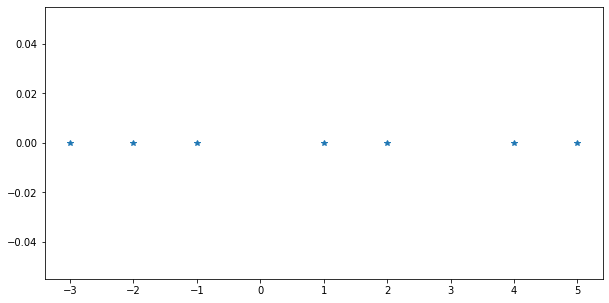

In [25]:
integr_result, number_intervals = adaptive_integration(f, -3, 5, tolerance, h_min)
print("Numerical  int.: {:.7f}, on {} sub-intervals, calling {} times "
      "the function.".format(integr_result, number_intervals, f.counter))

analytical_integr = 4 * atan(40) + 3 * atan(-30) - (1/20) * log(1601/901)
print("Analytical int.: {:.7f}".format(analytical_integr))

print("\nNumerical int. vs analytical int. error: {:.3e}".format(abs(integr_result - analytical_integr)))

The Python numerical implementation produces an absolute error of $1.259 \cdot 10^{-5}$ on the example proposed, compared to the analytical result.

Note: In case the function to evaluate is time-consuming, an easy performance improvement to implement could use [memoization](https://en.wikipedia.org/wiki/Memoization) ([practical Python implementation and examples](https://stackoverflow.com/questions/1988804/what-is-memoization-and-how-can-i-use-it-in-python)) to store results of the function already computed.